<a href="https://colab.research.google.com/github/kkogggokk/TextClassification/blob/SY/preprocessing/baseline_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import requirements

In [ ]:
# restart the runtime after installing the following packages 
!pip install wandb
!pip install transformers 

     |████████████████████████████████| 1.7 MB 7.2 MB/s 
     |████████████████████████████████| 97 kB 7.3 MB/s 
     |████████████████████████████████| 180 kB 63.7 MB/s 
     |████████████████████████████████| 139 kB 57.8 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=aa151d896852e6ba183a1b28fc7349f2889a9c5dbdd24d3b6a03e07499df5858
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=cb3b0acd85ef8b32d6b65ed03493efbb759166306db513cb65be78eff0a7aec6
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
     |████████████████████████████████| 3.1 MB 7.5 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |██████████████████████

In [ ]:
import os
import pdb
import wandb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict
import pandas as pd

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

# 1. Load data

In [ ]:
%cd "/content/drive/MyDrive/Competitions/Kaggle/Project1/data"
!pwd

/content/drive/MyDrive/Competitions/Kaggle/Project1/data
/content/drive/MyDrive/Competitions/Kaggle/Project1/data


In [ ]:
# !unzip goormtextclassificationproject.zip
# !ls .

In [ ]:
%cd .. 
!pwd

/content/drive/MyDrive/Competitions/Kaggle/Project1
/content/drive/MyDrive/Competitions/Kaggle/Project1


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Competitions/Kaggle/Project1/data"

In [ ]:
def load_data(file_name):
  data_strings = []
  with open(os.path.join(DATA_PATH, file_name), 'r', encoding='utf-8') as f:
    id_file_data = f.read().splitlines()
  return id_file_data

In [ ]:
train_pos_data = load_data("sentiment.train.1")
train_neg_data = load_data("sentiment.train.0")

dev_pos_data = load_data("sentiment.dev.1")
dev_neg_data = load_data("sentiment.dev.0")

In [ ]:
# make dataframes for EDA
train_pos_label = [1] * len(train_pos_data)
train_neg_label = [0] * len(train_neg_data)
train_df = pd.DataFrame({"text": train_pos_data + train_neg_data, "label": train_pos_label + train_neg_label})

dev_pos_label = [1] * len(dev_pos_data)
dev_neg_label = [0] * len(dev_neg_data)
dev_df = pd.DataFrame({"text": dev_pos_data + dev_neg_data, "label": dev_pos_label + dev_neg_label})

# 2. EDA

중복제거, sentiment 판단 어려운 문장들 제거 등 (neutral 등)

In [ ]:
train_df.describe(include="all")

# _num_ -> frequency

,text,label
count,443259,443259.000000
unique,380570,NaN
top,_num_ .,NaN
freq,1608,NaN
mean,NaN,0.600193
std,NaN,0.489859
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


In [ ]:
# null 확인
train_df.isna().any()

text     False
label    False
dtype: bool

In [ ]:
# 아예 똑같은 값들 
train_df[train_df.duplicated()].sort_values('text')

,text,label
432062,!,0
390671,!,0
354148,!,0
182817,!,1
208706,!,1
...,...,...
385891,zero stars .,0
282555,zero stars .,0
316781,zero stars .,0
384516,zero stars if i could .,0


In [ ]:
# text 가 똑같은 애들 
train_df[train_df.duplicated(['text'], keep=False)].sort_values('text')

,text,label
72345,!,1
157927,!,1
322425,!,0
197444,!,1
435916,!,0
...,...,...
431665,zero stars .,0
318041,zero stars .,0
297580,zero stars if i could .,0
384516,zero stars if i could .,0


In [ ]:
# text 는 같지만 label 은 다른 애들
75643 - 62604

13039

In [ ]:
# 중복 제거
train_df_unique = train_df.drop_duplicates()

In [ ]:
train_df_unique

,text,label
0,excellent food .,1
1,superb customer service .,1
2,they also have daily specials and ice cream wh...,1
3,it 's a good toasted hoagie .,1
4,the staff is friendly .,1
...,...,...
443251,"they dont refill your drinks , which i always ...",0
443252,"service slow , pizza and wings were horrible .",0
443253,"zero stars , if i could give it .",0
443255,does n't stop by to see if you need anything .,0


In [ ]:
train_text_dup = train_df_unique[train_df_unique.duplicated(['text'], keep=False)].sort_values('text')
train_text_dup_indices = train_text_dup.index.tolist()

In [ ]:
# text 는 같지만 label이 달랐던 값들 제거
new_train_df = train_df_unique.drop(train_text_dup_indices)
new_train_df.index = range(len(new_train_df.index))

In [ ]:
new_train_df

,text,label
0,excellent food .,1
1,superb customer service .,1
2,they also have daily specials and ice cream wh...,1
3,it 's a good toasted hoagie .,1
4,the staff is friendly .,1
...,...,...
380480,"they dont refill your drinks , which i always ...",0
380481,"service slow , pizza and wings were horrible .",0
380482,"zero stars , if i could give it .",0
380483,does n't stop by to see if you need anything .,0


In [ ]:
new_train_df.describe(include="all")

,text,label
count,380485,380485.000000
unique,380485,NaN
top,i will never go back to this kfc again .,NaN
freq,1,NaN
mean,NaN,0.585540
std,NaN,0.492629
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


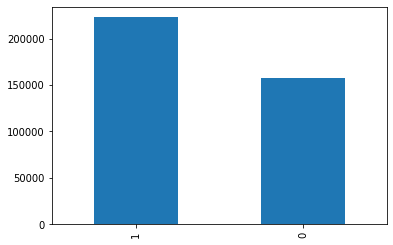

In [ ]:
new_train_df.label.value_counts().plot(kind="bar")

In [ ]:
dev_df.describe(include="all")

,text,label
count,4000,4000.000000
unique,3855,NaN
top,_num_ .,NaN
freq,25,NaN
mean,NaN,0.500000
std,NaN,0.500063
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.500000
75%,NaN,1.000000


In [ ]:
dev_df.isna().any()

text     False
label    False
dtype: bool

In [ ]:
# 아예 똑같은 값들 
dev_df[dev_df.duplicated()].sort_values('text')

,text,label
1389,!,1
2764,Negative,0
3172,Negative,0
1557,Neutral,1
3080,_num_ .,0
...,...,...
2298,wo n't be back .,0
1808,wow !,1
3797,wrong !,0
3075,wrong !,0


In [ ]:
# text 가 똑같은 애들 
dev_df[dev_df.duplicated(['text'], keep=False)].sort_values('text')

,text,label
80,!,1
1389,!,1
2764,Negative,0
3172,Negative,0
2338,Negative,0
...,...,...
3797,wrong !,0
3075,wrong !,0
2633,wrong !,0
1594,yeah !,1


In [ ]:
# text 는 같지만 label 은 다른 애들
223 - 143

80

In [ ]:
# 중복 제거
dev_df_unique = dev_df.drop_duplicates()

In [ ]:
dev_text_dup = dev_df_unique[dev_df_unique.duplicated(['text'], keep=False)].sort_values('text')
dev_text_dup_indices = dev_text_dup.index.tolist()

In [ ]:
# text 는 같지만 label이 달랐던 값들 제거
new_dev_df = dev_df_unique.drop(dev_text_dup_indices)
new_dev_df.index = range(len(new_dev_df.index))

In [ ]:
new_dev_df

,text,label
0,these donuts have the perfect texture and taste .,1
1,good food for the price .,1
2,"a little dirty on the inside , but wonderful p...",1
3,i always order it when i go there and it is al...,1
4,the rest of the food there is good also and no...,1
...,...,...
3848,i am sad to see how much this place has gone d...,0
3849,the food here is n't very good .,0
3850,it has n't been for quite a few years .,0
3851,the service the last time i went was just terr...,0


In [ ]:
new_dev_df.describe(include="all")

,text,label
count,3853,3853.000000
unique,3853,NaN
top,consistent & efficient .,NaN
freq,1,NaN
mean,NaN,0.499092
std,NaN,0.500064
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


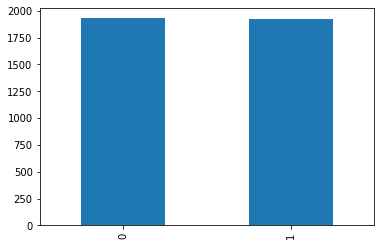

In [ ]:
new_dev_df.label.value_counts().plot(kind="bar")

# 3. Pre-process

In [ ]:
def tokenization(tokenizer, text_list):
  data_strings = []
  id_file_data = [tokenizer.encode(text.lower()) for text in text_list]
  for item in id_file_data:
    data_strings.append(' '.join([str(k) for k in item]))
  return data_strings

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
train_pos_list = new_train_df[new_train_df['label'] == 1]["text"].tolist()
train_neg_list = new_train_df[new_train_df['label'] == 0]["text"].tolist()

dev_pos_list = new_dev_df[new_dev_df['label'] == 1]["text"].tolist()
dev_neg_list = new_dev_df[new_dev_df['label'] == 1]["text"].tolist()

In [ ]:
# sentiment neutral 지워보기






In [ ]:
train_pos = tokenization(tokenizer, train_pos_list)
train_neg = tokenization(tokenizer, train_neg_list)

dev_pos = tokenization(tokenizer, dev_pos_list)
dev_neg = tokenization(tokenizer, dev_neg_list)

In [ ]:
train_pos[:10]

['0 3463 39462 689 479 2',
 '0 16101 428 2111 544 479 2',
 '0 10010 67 33 1230 24827 8 2480 6353 61 16 269 205 479 2',
 '0 405 128 29 10 205 7 14317 9379 1073 324 479 2',
 '0 627 813 16 5192 479 2',
 '0 8396 2003 689 479 2',
 '0 8396 544 479 2',
 '0 29 18615 9 183 16 17798 8 3739 9 24827 479 2',
 '0 12338 317 13 4592 50 2003 14967 8 4437 479 2',
 '0 627 92 1186 1326 2770 479 2']

In [ ]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [ ]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [ ]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([    0,  3463, 39462,   689,   479,     2]), array([1]))
(array([    0, 16101,   428,  2111,   544,   479,     2]), array([1]))
(array([    0, 10010,    67,    33,  1230, 24827,     8,  2480,  6353,
          61,    16,   269,   205,   479,     2]), array([1]))
(array([    0,   405,   128,    29,    10,   205,     7, 14317,  9379,
        1073,   324,   479,     2]), array([1]))
(array([   0,  627,  813,   16, 5192,  479,    2]), array([1]))
(array([   0, 8396, 2003,  689,  479,    2]), array([1]))
(array([   0, 8396,  544,  479,    2]), array([1]))
(array([    0,    29, 18615,     9,   183,    16, 17798,     8,  3739,
           9, 24827,   479,     2]), array([1]))
(array([    0, 12338,   317,    13,  4592,    50,  2003, 14967,     8,
        4437,   479,     2]), array([1]))
(array([   0,  627,   92, 1186, 1326, 2770,  479,    2]), array([1]))
(array([   0, 9226,  317,   21,  182,  205,  479,    2]), array([1]))


In [ ]:
def collate_fn_sentiment(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [ ]:
train_batch_size=64
eval_batch_size=64

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_sentiment,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=False, collate_fn=collate_fn_sentiment,
                                         num_workers=2)

# 3. Model

In [ ]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model.to(device)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

# 4. Train

In [ ]:
model.train()
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

In [ ]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [ ]:
train_epoch = 1
lowest_valid_loss = 9999.
for epoch in range(train_epoch):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            output = model(input_ids=input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=token_type_ids,
                           position_ids=position_ids,
                           labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())
            if iteration != 0 and iteration % int(len(train_loader) / 5) == 0:
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        output = model(input_ids=input_ids,
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                       position_ids=position_ids,
                                       labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)
                if lowest_valid_loss > valid_loss:
                    print('Acc for model which have lower valid loss: ', acc)
                    # torch.save(model.state_dict(), "pytorch_model.bin")
                    # json 형식으로 config 저장

Epoch 0:  20%|██        | 1191/5946 [03:03<1:01:55,  1.28batch/s, loss=0.231]

Acc for model which have lower valid loss:  0.5


Epoch 0:  40%|████      | 2380/5946 [06:05<46:20,  1.28batch/s, loss=0.158]

Acc for model which have lower valid loss:  0.499479979199168


Epoch 0:  60%|██████    | 3569/5946 [09:07<30:34,  1.30batch/s, loss=0.116]

Acc for model which have lower valid loss:  0.5


Epoch 0:  80%|████████  | 4758/5946 [12:08<15:22,  1.29batch/s, loss=0.175]

Acc for model which have lower valid loss:  0.5


Epoch 0: 100%|██████████| 5946/5946 [15:10<00:00,  6.53batch/s, loss=0.00238]

Acc for model which have lower valid loss:  0.5


# 6. Inference

In [ ]:
test_df = pd.read_csv(DATA_PATH + '/test_no_label.csv')

In [ ]:
test_dataset = test_df['Id']

In [ ]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [ ]:
test = make_id_file_test(tokenizer, test_dataset)

In [ ]:
test[:10]

['0 405 128 29 10 1086 92 676 8 92 14250 349 86 47 213 479 2',
 '0 2527 6770 31 41 793 2674 479 2',
 '0 405 16 5 144 12757 3553 1439 11 5 15044 479 2',
 '0 5016 45 1203 10 7792 19 209 82 479 2',
 '0 118 21 7464 8 79 156 162 619 98 3473 8 2814 479 2',
 '0 627 129 631 52 829 14 21 2131 21 5 3895 479 2',
 '0 2362 2156 45 5 1980 23 25 257 2156 5 1980 11 3812 239 479 2',
 '0 10010 836 24 66 760 13 47 8 32 182 7163 479 2',
 '0 7269 5 22633 222 295 75 190 216 141 7 173 5 3034 479 2',
 '0 10010 33 41 4206 4230 9 44505 7 2807 31 479 2']

In [ ]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [ ]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [ ]:
def collate_fn_sentiment_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)
    sorted_indices = [i for i in range(len(input_ids))]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [ ]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_sentiment_test,
                                          num_workers=2)

In [ ]:
with torch.no_grad():
    model.eval()
    predictions = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        output = model(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids,
                       position_ids=position_ids)

        logits = output.logits
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        predictions += batch_predictions


Test:  91%|█████████ | 29/32 [00:00<00:00, 36.22it/s]
                                                     

In [ ]:
test_df['Category'] = predictions

In [ ]:
test_df.to_csv('submission1.csv', index=False)

In [ ]:
!ls

data  submission1.csv		       submission_EDA_roBERTa.csv
log   submission_baseline_roBERTa.csv


In [ ]:
!pwd

/content/drive/My Drive/Competitions/Kaggle/Project1
